# Comparing Classification-Based S&P Prediction Models
## Modeling (Part 4)
### In this section we import relevant libraries and read the data

In [1]:
# Importing necessary libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
#
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
#
from sklearn import metrics
from sklearn import datasets, neighbors, metrics
%matplotlib inline

C:\Users\vchop\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read in daily returns over 2008 for 13 ETFs spy, shv (cash) and 11 sector ETFs
# The SectorModel2008 Excel spreadsheet has a worksheet "DailyRets" with returns and another 
# one "Names" with short and long-form names for the ETFs. 
# Appropriate number of rows are skipped at the top.
#
rets_d = pd.read_excel('SecModRets_2008_2012.xlsx', sheetname='DailyRets', skiprows=7, index_col=0)
names = pd.read_excel('SecModRets_2008_2012.xlsx', sheetname='Names', skiprows=1, index_col=0)

In [3]:
# Convert index to datetime format for isolating and analysis
dti = pd.to_datetime(rets_d.index) # gives time stamp
rets_d.index = dti # making the first col equal to time stamps
rets_d.drop(rets_d.index[0], inplace=True) #  the 12-31-2007 returns are dropped
#
# Change column names from tickers to short intuitive ones
short_nm = names['SHORT_NM'].astype(str).values.tolist()
rets_d.columns = short_nm
rets_d.head().round(3)

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,TELECOM,REAL_EST,CASH
Date,,,,,,,,,,,,,
2008-01-02,-0.875,-1.529,-1.424,0.189,-0.959,-1.660,-2.026,-1.048,-1.970,-0.567,NaN,NaN,0.100
2008-01-03,-0.048,-1.118,-0.528,1.182,1.816,0.078,0.153,0.601,-0.635,-0.143,NaN,NaN,-0.046
2008-01-04,-2.451,-3.141,-0.425,-3.655,-3.020,-2.050,-3.899,-1.024,-2.839,0.761,NaN,NaN,0.073
2008-01-07,-0.085,0.357,1.174,-0.387,-1.373,-1.245,-0.875,1.983,0.256,2.078,NaN,NaN,-0.055
2008-01-08,-1.615,-1.939,-0.738,-1.749,-1.542,-2.226,-2.648,0.817,-3.643,0.023,NaN,NaN,0.064


In [4]:
# Drop columns with all NAs
rets_d.dropna(axis=1, how='any', thresh=1000, inplace=True)
rets_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2008-01-02 to 2012-12-31
Data columns (total 11 columns):
S&P           1259 non-null float64
CONS_DISC     1259 non-null float64
CONS_STAP     1259 non-null float64
ENERGY        1259 non-null float64
MATERIAL      1259 non-null float64
INDUSTRIAL    1259 non-null float64
TECH          1259 non-null float64
HEALTH        1259 non-null float64
FINAN         1259 non-null float64
UTILITIES     1259 non-null float64
CASH          1259 non-null float64
dtypes: float64(11)
memory usage: 118.0 KB


In [5]:
# Exploratory analysis: descriptive stats
rets_d.describe().round(3)

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,CASH
count,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000
mean,0.020,0.052,0.032,0.026,0.023,0.023,0.026,0.026,0.008,0.010,0.003
std,1.651,1.806,1.030,2.334,2.044,1.787,1.652,1.265,3.004,1.375,0.031
min,-9.845,-11.625,-6.024,-14.444,-12.412,-9.405,-8.654,-9.783,-16.667,-7.440,-0.362
25%,-0.628,-0.728,-0.480,-1.000,-0.982,-0.813,-0.684,-0.510,-1.158,-0.581,-0.009
50%,0.065,0.077,0.076,0.054,0.095,0.082,0.081,0.055,0.000,0.033,0.000
75%,0.699,0.906,0.565,1.128,1.077,0.915,0.769,0.661,1.138,0.643,0.009
max,14.520,9.775,6.886,16.475,14.058,10.705,13.898,12.055,16.400,12.073,0.318


In [6]:
# Convert daily returns into an index of cumulative returns from the total returns.
# Then save Friday (weekly) close of the cumret series and calculate weekly returns.
# 
ETFs = rets_d.columns
cumret = pd.DataFrame(columns=ETFs)
for ETF in ETFs:
    cumret[ETF] = (1+rets_d[ETF]/100.0).cumprod()
print(rets_d.head().round(2))
print(cumret.head().round(4))

             S&P  CONS_DISC  CONS_STAP  ENERGY  MATERIAL  INDUSTRIAL  TECH  \
Date                                                                         
2008-01-02 -0.88      -1.53      -1.42    0.19     -0.96       -1.66 -2.03   
2008-01-03 -0.05      -1.12      -0.53    1.18      1.82        0.08  0.15   
2008-01-04 -2.45      -3.14      -0.42   -3.65     -3.02       -2.05 -3.90   
2008-01-07 -0.08       0.36       1.17   -0.39     -1.37       -1.25 -0.88   
2008-01-08 -1.61      -1.94      -0.74   -1.75     -1.54       -2.23 -2.65   

            HEALTH  FINAN  UTILITIES  CASH  
Date                                        
2008-01-02   -1.05  -1.97      -0.57  0.10  
2008-01-03    0.60  -0.63      -0.14 -0.05  
2008-01-04   -1.02  -2.84       0.76  0.07  
2008-01-07    1.98   0.26       2.08 -0.05  
2008-01-08    0.82  -3.64       0.02  0.06  
               S&P  CONS_DISC  CONS_STAP  ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                            

In [7]:
# Save Friday (or Thursday if Friday is a holiday) close and calculate weekly returns
cumret_w = cumret.resample('W-FRI').last()
print(cumret_w.head())
rets_w = cumret_w.pct_change(1)
print(rets_w.head())

                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-04  0.966487   0.943119   0.976389  0.976686  0.977938    0.963994   
2008-01-11  0.958553   0.925382   0.981597  0.952741  0.958753    0.930541   
2008-01-18  0.903221   0.902752   0.942708  0.868305  0.895683    0.885598   
2008-01-25  0.909924   0.943731   0.927083  0.865784  0.921823    0.914198   
2008-02-01  0.954654   1.005199   0.953819  0.899181  0.981295    0.966548   

                TECH    HEALTH     FINAN  UTILITIES      CASH  
Date                                                           
2008-01-04  0.942986  0.985273  0.946422   1.000472  1.001277  
2008-01-11  0.910728  1.032852  0.950570   1.025986  1.002555  
2008-01-18  0.866467  0.981875  0.881438   0.945665  1.004106  
2008-01-25  0.856714  0.934296  0.939509   0.901961  1.006022  
2008-02-01  0.887097  0.958935  1.025924   0.950626  1.007298  
     

In [8]:
# Exploratory analysis: correlations of daily returns
rets_w.corr().round(2)

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,CASH
S&P,1.00,0.93,0.84,0.87,0.89,0.95,0.92,0.82,0.86,0.74,-0.28
CONS_DISC,0.93,1.00,0.78,0.73,0.84,0.92,0.89,0.69,0.85,0.60,-0.20
CONS_STAP,0.84,0.78,1.00,0.67,0.68,0.78,0.77,0.81,0.64,0.73,-0.27
ENERGY,0.87,0.73,0.67,1.00,0.88,0.80,0.78,0.65,0.66,0.72,-0.28
MATERIAL,0.89,0.84,0.68,0.88,1.00,0.88,0.85,0.65,0.74,0.62,-0.25
INDUSTRIAL,0.95,0.92,0.78,0.80,0.88,1.00,0.88,0.73,0.84,0.67,-0.25
TECH,0.92,0.89,0.77,0.78,0.85,0.88,1.00,0.72,0.72,0.66,-0.27
HEALTH,0.82,0.69,0.81,0.65,0.65,0.73,0.72,1.00,0.64,0.69,-0.34
FINAN,0.86,0.85,0.64,0.66,0.74,0.84,0.72,0.64,1.00,0.51,-0.16
UTILITIES,0.74,0.60,0.73,0.72,0.62,0.67,0.66,0.69,0.51,1.00,-0.32


In [9]:
# Exploratory analysis: create weekly excess returns by subtracting the market return (SPY) from
# the sector returns. 
exc_rets_w = rets_w.sub(rets_w["S&P"], axis=0)
exc_rets_w.drop(["S&P", "CASH"], axis=1, inplace=True) # drop S&P and CASH to isolate sector rets

#exc_rets.CASH = rets_d.CASH # Do not create excess returns for CASH
print(exc_rets_w.head().round(4))

            CONS_DISC  CONS_STAP  ENERGY  MATERIAL  INDUSTRIAL    TECH  \
Date                                                                     
2008-01-04        NaN        NaN     NaN       NaN         NaN     NaN   
2008-01-11    -0.0106     0.0135 -0.0163   -0.0114     -0.0265 -0.0260   
2008-01-18     0.0333     0.0181 -0.0309   -0.0081      0.0094  0.0091   
2008-01-25     0.0380    -0.0240 -0.0103    0.0218      0.0249 -0.0187   
2008-02-01     0.0160    -0.0203 -0.0106    0.0154      0.0081 -0.0137   

            HEALTH   FINAN  UTILITIES  
Date                                   
2008-01-04     NaN     NaN        NaN  
2008-01-11  0.0565  0.0126     0.0337  
2008-01-18  0.0084 -0.0150    -0.0206  
2008-01-25 -0.0559  0.0585    -0.0536  
2008-02-01 -0.0228  0.0428     0.0048  


            CONS_DISC  CONS_STAP  ENERGY  MATERIAL  INDUSTRIAL    TECH  \
Date                                                                     
2008-01-11    -0.0106     0.0135 -0.0163   -0.0114     -0.0265 -0.0260   
2008-01-18     0.0333     0.0181 -0.0309   -0.0081      0.0094  0.0091   
2008-01-25     0.0380    -0.0240 -0.0103    0.0218      0.0249 -0.0187   
2008-02-01     0.0160    -0.0203 -0.0106    0.0154      0.0081 -0.0137   
2008-02-08     0.0071     0.0222  0.0256    0.0200      0.0023 -0.0104   

            HEALTH   FINAN  UTILITIES  
Date                                   
2008-01-11  0.0565  0.0126     0.0337  
2008-01-18  0.0084 -0.0150    -0.0206  
2008-01-25 -0.0559  0.0585    -0.0536  
2008-02-01 -0.0228  0.0428     0.0048  
2008-02-08  0.0245 -0.0396     0.0158  


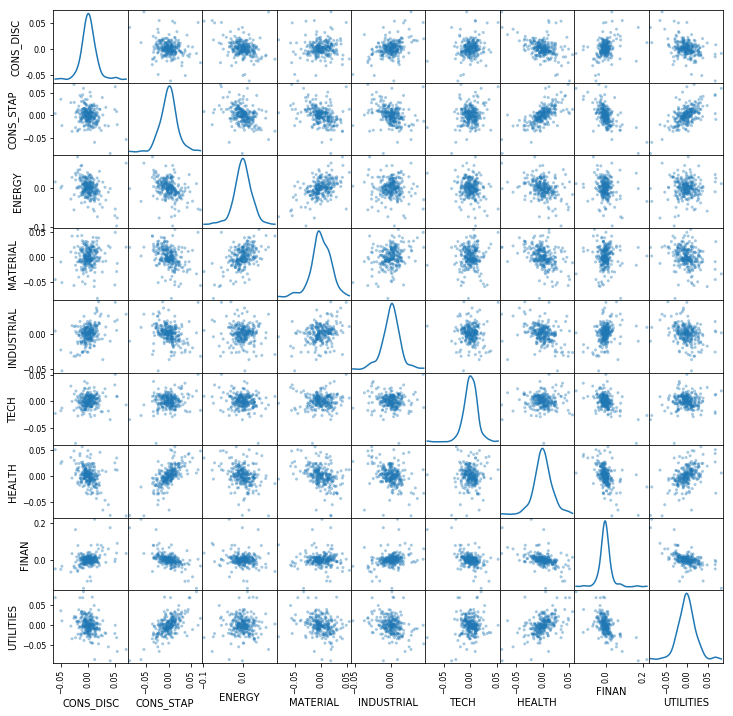

In [10]:
# Plot a scatter matrix of daily excess returns of sectors pairwise. This will reveal if
# any sectors that move together or move inversely
# Drop dataframe columns that have all NAs to avoid graph blowing up.
exc_rets_w_avail = exc_rets_w.dropna(axis = 0, how = "all")
print(exc_rets_w_avail.head().round(4))
#
pd.plotting.scatter_matrix(exc_rets_w_avail, diagonal='kde', alpha=0.4, figsize=(12,12))
plt.show()

In [11]:
# Calculate the correlation of excess returns
# These correlations will be much lower than for returns as we have removed the 
# common element of market returns
exc_rets_w.corr().round(2)

,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES
CONS_DISC,1.00,-0.19,-0.33,0.09,0.41,0.20,-0.40,0.31,-0.41
CONS_STAP,-0.19,1.00,-0.35,-0.36,-0.28,0.18,0.67,-0.59,0.60
ENERGY,-0.33,-0.35,1.00,0.49,-0.06,-0.18,-0.32,-0.16,0.04
MATERIAL,0.09,-0.36,0.49,1.00,0.30,0.06,-0.39,-0.01,-0.26
INDUSTRIAL,0.41,-0.28,-0.06,0.30,1.00,-0.05,-0.36,0.27,-0.29
TECH,0.20,0.18,-0.18,0.06,-0.05,1.00,0.01,-0.47,0.06
HEALTH,-0.40,0.67,-0.32,-0.39,-0.36,0.01,1.00,-0.47,0.48
FINAN,0.31,-0.59,-0.16,-0.01,0.27,-0.47,-0.47,1.00,-0.57
UTILITIES,-0.41,0.60,0.04,-0.26,-0.29,0.06,0.48,-0.57,1.00


In [12]:
# Forecsting daily returns using a combination of lagged s&p returns and sector excess returns
# y = S&P(t)
# X = [S&P(t-1), CONS_DISC(t-1), ....., REAL_EST(t-1)]
# spy_l is lagged S&P index
spy_w_l = rets_w[["S&P"]].shift(1)
exc_rets_w_l = exc_rets_w.shift(1) # lag exc rets by one pd. for regression

print(rets_w["S&P"].head())
print(spy_w_l.head())
print(type(spy_w_l))

print(exc_rets_w.head())
print(exc_rets_w_l.head())
print(type(exc_rets_w_l))

Date
2008-01-04         NaN
2008-01-11   -0.008209
2008-01-18   -0.057724
2008-01-25    0.007421
2008-02-01    0.049158
Freq: W-FRI, Name: S&P, dtype: float64
                 S&P
Date                
2008-01-04       NaN
2008-01-11       NaN
2008-01-18 -0.008209
2008-01-25 -0.057724
2008-02-01  0.007421
<class 'pandas.core.frame.DataFrame'>
            CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL      TECH  \
Date                                                                         
2008-01-04        NaN        NaN       NaN       NaN         NaN       NaN   
2008-01-11  -0.010598   0.013543 -0.016307 -0.011409   -0.026493 -0.025999   
2008-01-18   0.033269   0.018106 -0.030900 -0.008059    0.009425  0.009124   
2008-01-25   0.037972  -0.023995 -0.010324  0.021763    0.024875 -0.018676   
2008-02-01   0.015975  -0.020319 -0.010585  0.015358    0.008104 -0.013694   

              HEALTH     FINAN  UTILITIES  
Date                                       
2008-01-04       NaN 

In [13]:
# Convert market returns into 1 for positive and 0 for negative returns
# Our goal is to classify/predict future market returns into up (1) or down (0)
# which could be used to take positions in the market and make a profit
#
rets_w['up_dn'] = rets_w["S&P"].apply(lambda x: 1 if x > 0 else 0)
rets_w.head().round(3)

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,CASH,up_dn
Date,,,,,,,,,,,,
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2008-01-11,-0.008,-0.019,0.005,-0.025,-0.020,-0.035,-0.034,0.048,0.004,0.026,0.001,0
2008-01-18,-0.058,-0.024,-0.040,-0.089,-0.066,-0.048,-0.049,-0.049,-0.073,-0.078,0.002,0
2008-01-25,0.007,0.045,-0.017,-0.003,0.029,0.032,-0.011,-0.048,0.066,-0.046,0.002,1
2008-02-01,0.049,0.065,0.029,0.039,0.065,0.057,0.035,0.026,0.092,0.054,0.001,1


In [14]:
# assign independent and depend variables: ydf is dataframe of 1s and 0s
ydf = rets_w[["up_dn"]] # single square brackets turns it into a series

X = spy_w_l.join(exc_rets_w_l)
print(ydf.head())
print(X.head())

            up_dn
Date             
2008-01-04      0
2008-01-11      0
2008-01-18      0
2008-01-25      1
2008-02-01      1
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-04       NaN        NaN        NaN       NaN       NaN         NaN   
2008-01-11       NaN        NaN        NaN       NaN       NaN         NaN   
2008-01-18 -0.008209  -0.010598   0.013543 -0.016307 -0.011409   -0.026493   
2008-01-25 -0.057724   0.033269   0.018106 -0.030900 -0.008059    0.009425   
2008-02-01  0.007421   0.037972  -0.023995 -0.010324  0.021763    0.024875   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-04       NaN       NaN       NaN        NaN  
2008-01-11       NaN       NaN       NaN        NaN  
2008-01-18 -0.025999  0.056499  0.012592   0.033711  
2008-01-25  0.009124  0.008368 -0.015004  -0.020563  
200

In [15]:
# drop first row of y and X as the X values are NA due to lag of 1
ydf.drop(ydf.index[0:2], inplace=True)
X.drop(X.index[0:2], inplace=True)

print(ydf.head())
print(X.head())

            up_dn
Date             
2008-01-18      0
2008-01-25      1
2008-02-01      1
2008-02-08      0
2008-02-15      1
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-18 -0.008209  -0.010598   0.013543 -0.016307 -0.011409   -0.026493   
2008-01-25 -0.057724   0.033269   0.018106 -0.030900 -0.008059    0.009425   
2008-02-01  0.007421   0.037972  -0.023995 -0.010324  0.021763    0.024875   
2008-02-08  0.049158   0.015975  -0.020319 -0.010585  0.015358    0.008104   
2008-02-15 -0.046640   0.007090   0.022250  0.025617  0.020003    0.002254   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-18 -0.025999  0.056499  0.012592   0.033711  
2008-01-25  0.009124  0.008368 -0.015004  -0.020563  
2008-02-01 -0.018676 -0.055878  0.058462  -0.053636  
2008-02-08 -0.013694 -0.022787  0.042821   0.004797  
200

C:\Users\vchop\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# Classification models expect the target array to be a list so convert y to a list 
# Otherwise they give a warning
y = ydf["up_dn"].tolist()
#
print(ydf.head())
print(y[:5])
print(X.head())

type(y)

            up_dn
Date             
2008-01-18      0
2008-01-25      1
2008-02-01      1
2008-02-08      0
2008-02-15      1
[0, 1, 1, 0, 1]
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-18 -0.008209  -0.010598   0.013543 -0.016307 -0.011409   -0.026493   
2008-01-25 -0.057724   0.033269   0.018106 -0.030900 -0.008059    0.009425   
2008-02-01  0.007421   0.037972  -0.023995 -0.010324  0.021763    0.024875   
2008-02-08  0.049158   0.015975  -0.020319 -0.010585  0.015358    0.008104   
2008-02-15 -0.046640   0.007090   0.022250  0.025617  0.020003    0.002254   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-18 -0.025999  0.056499  0.012592   0.033711  
2008-01-25  0.009124  0.008368 -0.015004  -0.020563  
2008-02-01 -0.018676 -0.055878  0.058462  -0.053636  
2008-02-08 -0.013694 -0.022787  0.042821 

list

In [17]:
# Modified data starts from 2008-01-18 (after computing weekly return and lagging by 1 week)
rets_w.head()

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,CASH,up_dn
Date,,,,,,,,,,,,
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2008-01-11,-0.008209,-0.018807,0.005334,-0.024516,-0.019617,-0.034702,-0.034208,0.048290,0.004383,0.025502,0.001276,0
2008-01-18,-0.057724,-0.024455,-0.039618,-0.088624,-0.065783,-0.048299,-0.048600,-0.049356,-0.072727,-0.078287,0.001547,0
2008-01-25,0.007421,0.045393,-0.016575,-0.002903,0.029184,0.032295,-0.011255,-0.048457,0.065882,-0.046215,0.001908,1
2008-02-01,0.049158,0.065133,0.028839,0.038573,0.064516,0.057262,0.035464,0.026372,0.091979,0.053955,0.001268,1


In [18]:
# Drop the first two rows of y to align with X, i.e. 2008-01-18
yvar = rets_w["S&P"][2:].copy()

In [19]:
yvar.head()

Date
2008-01-18   -0.057724
2008-01-25    0.007421
2008-02-01    0.049158
2008-02-08   -0.046640
2008-02-15    0.015556
Freq: W-FRI, Name: S&P, dtype: float64

In [20]:
# To evaluate models we split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# The second split is for linreg model as we are using continuous yvar as the dependent variable
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, yvar, test_size=0.3, random_state=0)

In [21]:
# from sklearn import linear_model
# X is already defined above
# For linear regn, we will let y be an ordinal variable, i.e. not convert it to up/dn
print(yvar.head())
print(X.head())

# Fit the linear model
linreg = linear_model.LinearRegression(fit_intercept=False)

linreg.fit(X_train_lr, y_train_lr)
print("Accuracy of LinReg on training set: {:.3f}".format(linreg.score(X_train_lr, y_train_lr)))
print("Accuracy of LinReg on test set: {:.3f}".format(linreg.score(X_test_lr, y_test_lr)))

Date
2008-01-18   -0.057724
2008-01-25    0.007421
2008-02-01    0.049158
2008-02-08   -0.046640
2008-02-15    0.015556
Freq: W-FRI, Name: S&P, dtype: float64
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-18 -0.008209  -0.010598   0.013543 -0.016307 -0.011409   -0.026493   
2008-01-25 -0.057724   0.033269   0.018106 -0.030900 -0.008059    0.009425   
2008-02-01  0.007421   0.037972  -0.023995 -0.010324  0.021763    0.024875   
2008-02-08  0.049158   0.015975  -0.020319 -0.010585  0.015358    0.008104   
2008-02-15 -0.046640   0.007090   0.022250  0.025617  0.020003    0.002254   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-18 -0.025999  0.056499  0.012592   0.033711  
2008-01-25  0.009124  0.008368 -0.015004  -0.020563  
2008-02-01 -0.018676 -0.055878  0.058462  -0.053636  
2008-02-08 -0.013694 -0.

In [22]:
print(X.shape)
len(y)

(260, 10)


260

In [23]:
# Set up logistic regression and print parameters
#
lm = LogisticRegression(fit_intercept=False)
lm.fit(X_train, y_train)

print(lm.coef_.round(3))
print(lm.intercept_)
print(np.mean(y).round(3))

[[-0.224  0.072  0.11  -0.057  0.21   0.136  0.12  -0.029 -0.139 -0.1  ]]
0.0
0.535


In [24]:
# predict class labels for the test set
predicted = lm.predict(X_test)
print(predicted)

[0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1
 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0
 0 1 0 0]


In [25]:
# generate class probabilities
probs = lm.predict_proba(X_test)
print(probs[:5])

[[ 0.5009921   0.4990079 ]
 [ 0.49838328  0.50161672]
 [ 0.50241147  0.49758853]
 [ 0.50005319  0.49994681]
 [ 0.499315    0.500685  ]]


In [26]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.551282051282
0.551630434783


In [27]:
# Confusion matrix and classification report
#
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[19 13]
 [22 24]]
             precision    recall  f1-score   support

          0       0.46      0.59      0.52        32
          1       0.65      0.52      0.58        46

avg / total       0.57      0.55      0.55        78



In [28]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.51851852  0.53846154  0.53846154  0.53846154  0.53846154  0.53846154
  0.53846154  0.53846154  0.53846154  0.52      ]
0.534621082621


In [29]:
# Classification using K-Nearest Neighbors
# n_neighbors is our option in KNN. We'll tune this value to attempt to improve our prediction.
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
#print(knn.predict(X))
#print(y)

print("Accuracy of KNN on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy of KNN on test set: {:.3f}".format(knn.score(X_test, y_test)))

Accuracy of KNN on training set: 0.692
Accuracy of KNN on test set: 0.564


In [30]:
# Set up a decision tree classifier
dec_tree = DecisionTreeClassifier(max_depth=6)

# Fits the model
dec_tree.fit(X_train, y_train)

print("Accuracry on training set: {:.3f}".format(dec_tree.score(X_train, y_train)))

print("Accuracy on test set: {:.3f}".format(dec_tree.score(X_test, y_test)))

Accuracry on training set: 0.896
Accuracy on test set: 0.538


In [31]:
dec_tree.feature_importances_

array([ 0.14231442,  0.08899824,  0.1414042 ,  0.04271681,  0.19911229,
        0.10696577,  0.0413901 ,  0.022879  ,  0.08849833,  0.12572085])

In [32]:
# Optional: Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(dec_tree):
    dotfile = open("tree_w.dot", 'w')
    export_graphviz(dec_tree,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree_w.dot -o tree-W.png")

build_tree_image(dec_tree) # creates tree.png tree

In [33]:
# Random forest classifier
rforest = RandomForestClassifier(n_estimators = 6, max_depth = 4)
rforest.fit(X_train, y_train)

print("Accuracy of RF on training set: {:.3f}".format(rforest.score(X_train, y_train)))
print("Accuracy of RF on test set: {:.3f}".format(rforest.score(X_test, y_test)))

Accuracy of RF on training set: 0.808
Accuracy of RF on test set: 0.474


In [34]:
# Boosting model
adaboost = AdaBoostClassifier(n_estimators=7)
adaboost.fit(X_train, y_train)
print("Accuracy of AB on training set: {:.3f}".format(adaboost.score(X_train, y_train)))
print("Accuracy of AB on test set: {:.3f}".format(adaboost.score(X_test, y_test)))

Accuracy of AB on training set: 0.681
Accuracy of AB on test set: 0.513


In [35]:
# Bagging algorithm
bclass = BaggingClassifier(n_estimators=2, max_features=10)
bclass.fit(X_train, y_train)
print("Accuracy of Bagg on training set: {:.3f}".format(bclass.score(X_train, y_train)))
print("Accuracy of Bagg on test set: {:.3f}".format(bclass.score(X_test, y_test)))

Accuracy of Bagg on training set: 0.819
Accuracy of Bagg on test set: 0.410
